In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import config
api_key = config.api_key
import requests
from bs4 import BeautifulSoup
import re
import datetime


# remove scientific notation display for floats
pd.set_option('display.float_format', lambda x: '%.5f' % x)

ModuleNotFoundError: No module named 'config'

# WEBSCRAPPING TEST

In [474]:
test_ids = tmdb_df.loc[4100:4200].imdb_id

In [475]:
test_ids = test_ids.dropna()

In [476]:
def scrape_budget(imdb_id):
    url = 'https://www.imdb.com/title/'
    html_page = requests.get(url+imdb_id)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    details = soup.find('div', id="titleDetails")
    budget = details.find(text=re.compile('Budget:'))
    try:
      return budget.parent.parent.contents[2]
    except:
      return "0"
results = []
for id in test_ids:
    results.append(scrape_budget(id))

KeyboardInterrupt: 

In [ ]:
results

In [ ]:
for bud in tmdb_df.loc[4100:4200].budget:
    print(bud)

Testing scm_breeze again


# Data Sources and Notes:

## Box Office Mojo

### Box Office Mojo movie grosses

In [478]:
#read data
gross_bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz', compression='gzip')
gross_bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
title             3387 non-null object
studio            3382 non-null object
domestic_gross    3359 non-null float64
foreign_gross     2037 non-null object
year              3387 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


## Note: Not all movies have information for foreign gross earnings. To suplement foreign gross when not available we will use the ratio of the average (median) domestic to foreign gross, and then make a column for total gross earnings

In [479]:
# Foreign Gross is a string accounting for NaN.
# Creating foreign_release column in order to create expected foreign gross column.
gross_bom['no_foreign_release'] = gross_bom.foreign_gross.map(lambda x : pd.isnull(x))

In [480]:
print(gross_bom['no_foreign_release'].value_counts())
gross_bom.foreign_gross.isna().sum()

False    2037
True     1350
Name: no_foreign_release, dtype: int64


1350

In [481]:
# remove na rows from foreign_gross in order to calculate stats
no_na_foreign_gross = gross_bom.dropna(axis= 0, subset=['foreign_gross'])

In [482]:
# remove comma from string then convert to int
no_na_foreign_gross.foreign_gross = no_na_foreign_gross.foreign_gross.map(lambda val : int(float(val.replace(",", ""))))

/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [483]:
no_na_foreign_gross.agg(['mean', 'median', 'std'])

,domestic_gross,foreign_gross,year,no_foreign_release
mean,46973114.37780,74872810.14973,2013.49288,0.00000
median,16500000.00000,18700000.00000,2013.00000,0.00000
std,81599661.10596,137410600.84191,2.59241,0.00000


In [484]:
# find ratio of domestic to foreign mean
no_na_foreign_gross.domestic_gross.mean()/no_na_foreign_gross.foreign_gross.mean()

0.6273721299342642

In [485]:
# find ratio of domestic to foreign median
no_na_foreign_gross.domestic_gross.median()/no_na_foreign_gross.foreign_gross.median()

0.8823529411764706

In [486]:
# set foreign_gross na's to 0 in order to do arithmetic operations
gross_bom.foreign_gross.fillna("0", inplace=True)

In [487]:
# convert foreign_gross strings to int
gross_bom.foreign_gross = gross_bom.foreign_gross.map(lambda val : int(float(val.replace(",", ""))))

In [488]:
no_na_data = {'dom_median': no_na_foreign_gross.domestic_gross.median(), 'foreign_median': no_na_foreign_gross.foreign_gross.median()}

In [489]:
def total_gross(no_foreign_release, domestic_gross, foreign_gross):
    if no_foreign_release:
        return domestic_gross*(no_na_data['foreign_median']/no_na_data['dom_median'])
    else:
        return domestic_gross + foreign_gross

In [490]:
gross_bom['total_gross'] = gross_bom.apply(lambda row : total_gross(row.no_foreign_release, row.domestic_gross, row.foreign_gross), axis=1)

In [491]:
gross_bom.loc[gross_bom.no_foreign_release == True].head()

,title,studio,domestic_gross,foreign_gross,year,no_foreign_release,total_gross
222,Flipped,WB,1800000.00000,0,2010,True,2040000.00000
254,The Polar Express (IMAX re-issue 2010),WB,673000.00000,0,2010,True,762733.33333
267,Tiny Furniture,IFC,392000.00000,0,2010,True,444266.66667
269,Grease (Sing-a-Long re-issue),Par.,366000.00000,0,2010,True,414800.00000
280,Last Train Home,Zeit.,288000.00000,0,2010,True,326400.00000


# <span style="color:blue"> Done: Make total gross column </span>

## IMDB
Note: foreign keys look like nconst is for Person Name, and tconst is for Movie Title

### IMDB Basic info by Name

In [492]:
name_basics_imdb = pd.read_csv('zippedData/imdb.name.basics.csv.gz', compression='gzip')
name_basics_imdb.head(1)

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,nan,nan,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"


### IMDB some kind of info by Title
# <span style="color:red"> I think this is related to international releases? I can't tell yet </span>

In [493]:
title_imdb = pd.read_csv('zippedData/imdb.title.akas.csv.gz', compression='gzip')
title_imdb.head(2)

,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.00000
1,tt0369610,11,Jurashikku warudo,JP,NaN,imdbDisplay,NaN,0.00000


### IMDB Basic info by Title

In [494]:
title_basics_imdb = pd.read_csv('zippedData/imdb.title.basics.csv.gz', compression='gzip')
title_basics_imdb.head(1)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00000,"Action,Crime,Drama"


### Remove NaN rows from genres (as we are only looking at Animated films, we are not concerned with losing the data)

In [495]:
title_basics_imdb.dropna(axis= 0, subset=['genres'], inplace=True)

In [496]:
title_basics_imdb['is_animated'] = title_basics_imdb.apply(lambda row : 'Animation' in row.genres, axis=1)

## Create Animated Films DF

In [497]:
animated_films_df = title_basics_imdb.loc[title_basics_imdb['is_animated'] == True]

In [498]:
len(animated_films_df)

2799

## Create non-animated films for comparison

In [499]:
non_animated_films_df = title_basics_imdb.loc[title_basics_imdb['is_animated'] == False]

In [500]:
len(non_animated_films_df)

137937

### IMDB Crew (Writers and Directors)
This looks to be a connecting table

In [501]:
crew_imdb = pd.read_csv('zippedData/imdb.title.crew.csv.gz', compression='gzip')
crew_imdb.head(1)

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854


### IMDB Principles
(Actors, directors, producers, editors, actress, composer, cinematographer, writer, self, production designer, archive footage, archive sound )

In [502]:
title_principals_imdb = pd.read_csv('zippedData/imdb.title.principals.csv.gz', compression='gzip')
title_principals_imdb.head(1)

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"


### IMDB Rating
Key for titles along with rating and number of votes

In [503]:
title_ratings_imdb = pd.read_csv('zippedData/imdb.title.ratings.csv.gz', compression='gzip')
title_ratings_imdb.head(1)

,tconst,averagerating,numvotes
0,tt10356526,8.30000,31


## Rotten Tomatos

### Rotten Tomatos info
# <span style="color:red">  Note: No title, assuming id links to title somewhere</span>

In [504]:
info_rotten_tom = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t', compression='gzip')
info_roten_tom.head(1)

NameError: name 'info_roten_tom' is not defined

### Rotten Tomatos Reviews
# <span style="color:red">  Note: Also no titles, assuming id links to title but don't seem to have that data</span>

In [505]:
reviews_rotten_tom = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', compression='gzip', encoding="cp1252")
reviews_rotten_tom.head(1)

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"


## The Movie DataBase

### TMDB info

In [506]:
movies_movie_db = pd.read_csv('zippedData/tmdb.movies.csv.gz', compression='gzip')
# movies_movie_db.loc[movies_movie_db['id']==1]
movies_movie_db

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.53300,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.70000,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.73400,2010-03-26,How to Train Your Dragon,7.70000,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.51500,2010-05-07,Iron Man 2,6.80000,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.00500,1995-11-22,Toy Story,7.90000,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.92000,2010-07-16,Inception,8.30000,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.60000,2018-10-13,Laboratory Conditions,0.00000,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.60000,2018-05-01,_EXHIBIT_84xxx_,0.00000,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.60000,2018-10-01,The Last One,0.00000,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.60000,2018-06-22,Trailer Made,0.00000,1


In [507]:
# movies_movie_db.loc[movies_movie_db.genre_ids == [16]]
TMDB_movies_df = movies_movie_db[movies_movie_db['genre_ids'].str.contains('16')]

### TMDB budgets
# <span style="color:red"> What does the ID mean? </span>

In [508]:
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', compression='gzip')
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [509]:
movie_budgets.production_budget = movie_budgets.production_budget.map(lambda budget : int(budget.replace('$', '').replace(',', '')))

In [510]:
movie_budgets.worldwide_gross = movie_budgets.worldwide_gross.map(lambda budget : int(budget.replace('$', '').replace(',', '')))

# Combining DF containing name and genre with DF containing budgets and returns

In [511]:
TMDB_merge_df = pd.merge(TMDB_movies_df, movie_budgets, how='inner', left_on='title'.lower(), right_on='movie'.lower())

In [512]:
TMDB_merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 148
Data columns (total 16 columns):
Unnamed: 0           149 non-null int64
genre_ids            149 non-null object
id_x                 149 non-null int64
original_language    149 non-null object
original_title       149 non-null object
popularity           149 non-null float64
release_date_x       149 non-null object
title                149 non-null object
vote_average         149 non-null float64
vote_count           149 non-null int64
id_y                 149 non-null int64
release_date_y       149 non-null object
movie                149 non-null object
production_budget    149 non-null int64
domestic_gross       149 non-null object
worldwide_gross      149 non-null int64
dtypes: float64(2), int64(6), object(8)
memory usage: 19.8+ KB


In [513]:
animated_merge_df = pd.merge(animated_films_df, movie_budgets, how='inner', left_on='primary_title'.lower(), right_on='movie'.lower())


In [514]:
animated_merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148 entries, 0 to 147
Data columns (total 13 columns):
tconst               148 non-null object
primary_title        148 non-null object
original_title       148 non-null object
start_year           148 non-null int64
runtime_minutes      137 non-null float64
genres               148 non-null object
is_animated          148 non-null bool
id                   148 non-null int64
release_date         148 non-null object
movie                148 non-null object
production_budget    148 non-null int64
domestic_gross       148 non-null object
worldwide_gross      148 non-null int64
dtypes: bool(1), float64(1), int64(4), object(7)
memory usage: 15.2+ KB


In [515]:
non_animated_merge_df = pd.merge(non_animated_films_df, movie_budgets, how='inner', left_on='primary_title'.lower(), right_on='movie'.lower())

In [516]:
animated_merge_df.loc[animated_merge_df.production_budget == animated_merge_df.production_budget.max()]

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,is_animated,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
1,tt0398286,Tangled,Tangled,2010,100.00000,"Adventure,Animation,Comedy",True,15,"Nov 24, 2010",Tangled,260000000,"$200,821,936",586477240


In [517]:
animated_merge_df.loc[animated_merge_df.production_budget == animated_merge_df.production_budget.max()]

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,is_animated,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
1,tt0398286,Tangled,Tangled,2010,100.00000,"Adventure,Animation,Comedy",True,15,"Nov 24, 2010",Tangled,260000000,"$200,821,936",586477240


In [518]:
len(animated_merge_df)

148

## Initial plot of budget to world wide gross for animated films:

In [519]:
animated_merge_df.production_budget.max()

260000000

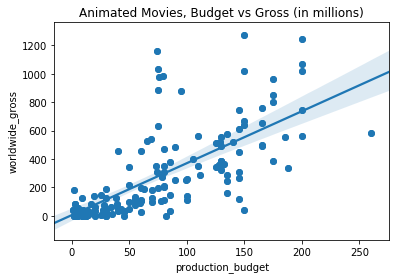

In [520]:
fig, ax = plt.subplots()
animated_scatter = ax.scatter(animated_merge_df['production_budget']/1e6, animated_merge_df['worldwide_gross']/1e6)
ax.set_xlabel("Production Budget (M)")
ax.set_ylabel("Worldwide Gross (M)")
ax.set_title("Animated Movies, Budget vs Gross (in millions)")
sns.regplot(animated_merge_df['production_budget']/1e6, animated_merge_df['worldwide_gross']/1e6)

## Initial plot of budget to world wide gross for non-animated films:

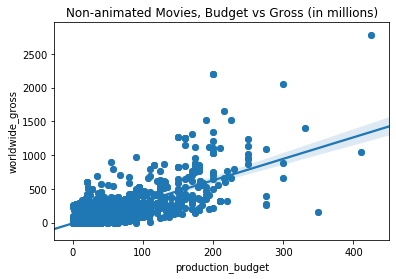

In [521]:
fig, ax = plt.subplots()
ax.scatter(non_animated_merge_df['production_budget']/1e6, non_animated_merge_df['worldwide_gross']/1e6)
ax.set_xlabel("Production Budget (M)")
ax.set_ylabel("Worldwide Gross (M)")
ax.set_title("Non-animated Movies, Budget vs Gross (in millions)")
sns.regplot(non_animated_merge_df['production_budget']/1e6, non_animated_merge_df['worldwide_gross']/1e6)

# TMDB API Results

In [522]:
# CHANGED CALL TO SORT BY REVENUE AFTER MAKING all_movies LIST!!!
def call_TMDB_api(page):
    return requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' +  api_key + '&with_genres=16&sort_by=revenue.desc&page='+ page).json()['results']

first_call = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' +  api_key + '&with_genres=16&sort_by=revenue.desc')
num_pages = first_call.json()['total_pages']

In [ ]:
# commenting this out so I don't accidentally make another 500 api calls

# results = []
# for i in range(num_pages):
#     results += call_TMDB_api(str(i+1))

In [ ]:
def turn_response_into_list(response):
    details = []
    for movie in response:
        details.append(requests.get('https://api.themoviedb.org/3/movie/'+ str(movie['id']) +'?api_key='+ api_key).json())
    return details

In [ ]:
# THIS TAKES 23 MINUTES TO RUN!!!!

# all_movies = turn_response_into_list(results)

In [ ]:
# THIS TAKES 23 MINUTES TO RUN!!!!

# results_by_rev = turn_response_into_list(results)

### TEST to make sure results from API are consistent:

In [323]:
# THIS TAKES 23 MINUTES TO RUN!!!!

# compare_results_by_rev = turn_response_into_list(results)

In [523]:
compare_results_by_rev == results_by_rev

True

In [28]:
keys = all_movies[1].keys()

In [36]:
tmdb_data = pd.DataFrame(all_movies, columns = keys)

Index(['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'id', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [290]:
tmdb_data_by_revenue = pd.DataFrame(results_by_rev, columns = keys)

In [291]:
# tmdb_data_by_revenue.to_csv('tmdb_animation_by_revenue.csv')

In [33]:
# tmdb_data.to_csv('tmdb_animation.csv')

# Import new csv from what we made up there ^^^

In [113]:
tmdb_df = pd.read_csv('Data/tmdb_animation.csv', index_col=None, header=0, engine='python' )


In [430]:
tmdb_by_revenue_df = pd.read_csv('Data/tmdb_animation_by_revenue.csv', index_col=None, header=0, engine='python' )

## Drop rows where revenue is 0

In [119]:
tmdb_df.dropna(axis=0, subset=['revenue'], inplace=True)

In [328]:
tmdb_by_revenue_df.dropna(axis=0, subset=['revenue'], inplace=True)

In [327]:
tmdb_df.groupby(['budget', 'title']).sum().sort_values(by='budget', ascending=False).head(500)

id  \
budget     title                                                             
998000.0   Revolutionary Girl Utena: The Adolescence of Utena  19738.00000   
99000000.0 The Peanuts Movie                                  227973.00000   
9577.0     Night                                               39092.00000   
95000000.0 The Road to El Dorado                               10501.00000   
           Ice Age: Continental Drift                          57800.00000   
...                                                                    ...   
2000000.0  Rio 2096: A Story of Love and Fury                 173443.00000   
           The Amazing Zorro                                  275519.00000   
           Strange Frame: Love & Sax                          205392.00000   
           The Happy Cricket and the Giant Bugs               205949.00000   
           Waltz with Bashir                                    8885.00000   

                                                                      revenue  \
budget     title                                                                
998000.0   Revolutionary Girl Utena: The Adolescence of Utena         0.00000   
99000000.0 The Peanuts Movie                                  246233113.00000   
9577.0     Night                                                      0.00000   
95000000.0 The Road to El Dorado                               76432727.00000   
           Ice Age: Continental Drift                         877244782.00000   
...                                                                       ...   
2000000.0  Rio 2096: A Story of Love and Fury                         0.00000   
           The Amazing Zorro                                          0.00000   
           Strange Frame: Love & Sax                                  0.00000   
           The Happy Cricket and the Giant Bugs                       0.00000   
           Waltz with Bashir                                   11125849.00000   

                                                               runtime  \
budget     title                                                         
998000.0   Revolutionary Girl Utena: The Adolescence of Utena 87.00000   
99000000.0 The Peanuts Movie                                  88.00000   
9577.0     Night                                               7.00000   
95000000.0 The Road to El Dorado                              89.00000   
           Ice Age: Continental Drift                         88.00000   
...                                                                ...   
2000000.0  Rio 2096: A Story of Love and Fury                 74.00000   
           The Amazing Zorro                                  72.00000   
           Strange Frame: Love & Sax                          98.00000   
           The Happy Cricket and the Giant Bugs               85.00000   
           Waltz with Bashir                                  90.00000   

                                                               vote_average  \
budget     title                                                              
998000.0   Revolutionary Girl Utena: The Adolescence of Utena       7.30000   
99000000.0 The Peanuts Movie                                        6.70000   
9577.0     Night                                                    4.60000   
95000000.0 The Road to El Dorado                                    7.20000   
           Ice Age: Continental Drift                               6.30000   
...                                                                     ...   
2000000.0  Rio 2096: A Story of Love and Fury                       7.60000   
           The Amazing Zorro                                        6.30000   
           Strange Frame: Love & Sax                                5.40000   
           The Happy Cricket and the Giant Bugs                     0.00000   
           Waltz with Bashir                                        7.80000   

            

In [322]:
tmdb_by_revenue_df.groupby('revenue').sum().sort_values(by='revenue', ascending=False).head(500)

,id,runtime,vote_average,vote_count
revenue,,,,
1330764959.00000,330457.00000,104.00000,7.20000,4647.00000
1274219009.00000,109445.00000,102.00000,7.30000,11832.00000
1242805359.00000,260513.00000,118.00000,7.50000,8400.00000
1156730962.00000,211672.00000,91.00000,6.40000,8057.00000
1073394593.00000,301528.00000,100.00000,7.60000,5034.00000
...,...,...,...,...
1015339.00000,366170.00000,120.00000,6.80000,99.00000
1000000.00000,337203.00000,167.00000,9.10000,8.00000
955401.00000,47542.00000,81.00000,6.30000,15.00000


In [310]:
tmdb_df.dropna(axis=0, subset=['budget'], inplace=True)

In [313]:
tmdb_by_revenue_df.dropna(axis=0, subset=['budget'], inplace=True)

In [311]:
len(tmdb_df)

9990

In [314]:
len(tmdb_by_revenue_df)

9978

In [315]:
tmdb_df.budget.value_counts()

0.0           9249
10000000.0      29
3500000.0       20
30000000.0      19
20000000.0      18
              ... 
12516654.0       1
4.0              1
78000000.0       1
38.0             1
47000000.0       1
Name: budget, Length: 341, dtype: int64

In [317]:
tmdb_by_revenue_df.budget.value_counts()

0.0           9436
30000000.0      16
80000000.0      16
10000000.0      15
75000000.0      14
              ... 
3700.0           1
46597700.0       1
2617.0           1
47000000.0       1
3747230.0        1
Name: budget, Length: 234, dtype: int64

Turn budget to int.

In [330]:
tmdb_by_revenue_df['budget'] = pd.to_numeric(tmdb_df['budget'])

In [403]:
tmdb_by_revenue_df = tmdb_by_revenue_df[tmdb_by_revenue_df.revenue >= 10000]

In [407]:
tmdb_by_revenue_df.sort_values(by='budget', ascending=False)

,Unnamed: 0,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
83,83,False,/cI0E3ytJlHkL66pDMyp3TIf7VmV.jpg,NaN,260000000.00000,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.wbshop.com/Tom-and-Jerry-Meet-Sherl...,43956.00000,tt1722638,en,...,2010-08-24,347988775.00000,49.00000,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Released,NaN,Tom and Jerry Meet Sherlock Holmes,False,6.90000,27.00000
4,4,False,/q62bpQ67qaXY0u6b2wFEnQYIbPd.jpg,"{'id': 10194, 'name': 'Toy Story Collection', ...",200000000.00000,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",https://www.pixar.com/feature-films-toy-story-4,301528.00000,tt1979376,en,...,2019-06-19,1073394593.00000,100.00000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Get Ready to Hit the Road,Toy Story 4,False,7.60000,5034.00000
163,163,False,/aMdz0ngZaAsKvlbOCIXieHd9fgD.jpg,"{'id': 694602, 'name': 'Anastasia Collection',...",200000000.00000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",NaN,9444.00000,tt0118617,en,...,1997-11-20,139804348.00000,94.00000,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Discover the Adventure Behind the Greatest Mys...,Anastasia,False,7.60000,3772.00000
32,32,False,/sKTFNMsuSgyAcwbD0xXVUXvvbY.jpg,"{'id': 89137, 'name': 'How to Train Your Drago...",200000000.00000,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...",http://www.howtotrainyourdragon.com/,82702.00000,tt1646971,en,...,2014-06-09,609123048.00000,102.00000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The training is over.,How to Train Your Dragon 2,False,7.70000,6603.00000
69,69,False,/uUiId6cG32JSRI6RyBQSvQtLjz2.jpg,"{'id': 573436, 'name': 'Spider-Man: Spider-Ver...",200000000.00000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.intothespiderverse.movie,324857.00000,tt4633694,en,...,2018-12-06,375540831.00000,117.00000,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,More Than One Wears the Mask,Spider-Man: Into the Spider-Verse,False,8.40000,7248.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,155,False,/qOfUKwYsRLaZJIdkTdQyNeeGc2f.jpg,"{'id': 436295, 'name': ""Surf's Up Collection"",...",812000.00000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",https://www.sonypictures.com/movies/surfsup,9408.00000,tt0423294,en,...,2007-06-08,149044513.00000,85.00000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"In the coldest place on Earth, he's the hottes...",Surf's Up,False,6.20000,1525.00000
606,606,False,/xTXF2udD4iOiLeh1ZMtee7YVu7k.jpg,NaN,590235.00000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,228692.00000,tt2361846,en,...,2014-04-23,15077.00000,72.00000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Cheatin',False,7.70000,17.00000
334,334,False,/ob4XnKBqAh1rg381hayebJx6EkE.jpg,NaN,315000.00000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",https://www.missinglink.movie/,458253.00000,tt6348138,en,...,2019-04-04,16649539.00000,95.00000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Meet Mr. Link,Missing Link,False,7.00000,375.00000
590,590,False,/w5XEKGEGG2AXp7tiXjcsEuxn7i5.jpg,NaN,132.00000,"[{'id': 16, 'name': 'Animation'}, {'id': 28, '...",http://www.thresholdanimationstudios.com/video...,116977.00000,tt0249516,en,...,2012-06-15,73706.00000,87.00000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Foodfight!,False,1.70000,75.00000


In [397]:
tmdb_by_revenue_df = tmdb_by_revenue_df[tmdb_by_revenue_df.budget != 0]

In [469]:
tmdb_by_revenue_df.corr()

,budget,id,revenue,runtime,vote_average,vote_count
budget,1.00000,-0.16195,0.45284,0.15499,0.16834,0.40723
id,-0.16195,1.00000,-0.17295,-0.01978,-0.23059,-0.29217
revenue,0.45284,-0.17295,1.00000,0.26518,0.24799,0.81137
runtime,0.15499,-0.01978,0.26518,1.00000,0.30983,0.24685
vote_average,0.16834,-0.23059,0.24799,0.30983,1.00000,0.34818
vote_count,0.40723,-0.29217,0.81137,0.24685,0.34818,1.00000


In [528]:
non_animated_merge_df.sort_values(by='worldwide_gross', ascending=False)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,is_animated,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
1608,tt1775309,Avatar,Abatâ,2011,93.00000,Horror,False,1,"Dec 18, 2009",Avatar,425000000,"$760,507,625",2776345279
2586,tt2495766,Titanic,Titanic,2012,nan,Adventure,False,43,"Dec 19, 1997",Titanic,200000000,"$659,363,944",2208208395
2587,tt8852130,Titanic,Titanic,2018,115.00000,Family,False,43,"Dec 19, 1997",Titanic,200000000,"$659,363,944",2208208395
3151,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.00000,"Action,Adventure,Sci-Fi",False,7,"Apr 27, 2018",Avengers: Infinity War,300000000,"$678,815,482",2048134200
9,tt0369610,Jurassic World,Jurassic World,2015,124.00000,"Action,Adventure,Sci-Fi",False,34,"Jun 12, 2015",Jurassic World,215000000,"$652,270,625",1648854864
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3352,tt5462288,Rockaway,Rockaway,2017,90.00000,"Adventure,Drama",False,84,"Jul 7, 2007",Rockaway,2000000,$0,0
1457,tt1702455,Archaeology of a Woman,Archaeology of a Woman,2012,94.00000,Drama,False,38,"Sep 12, 2014",Archaeology of a Woman,200000,$0,0
2403,tt2294916,The Image Revolution,The Image Revolution,2014,81.00000,"Biography,Documentary",False,26,"Dec 31, 2014",The Image Revolution,50000,$0,0
1489,tt1717210,Should've Been Romeo,Should've Been Romeo,2012,nan,"Comedy,Drama",False,96,"Dec 31, 2012",Should've Been Romeo,5000000,$0,0


In [527]:
non_animated_merge_df.production_budget.corr(non_animated_merge_df.worldwide_gross)

0.7611268931415269

In [532]:
non_animated_merge_df.worldwide_gross.mean()/non_animated_merge_df.production_budget.mean()

2.7952292875277127

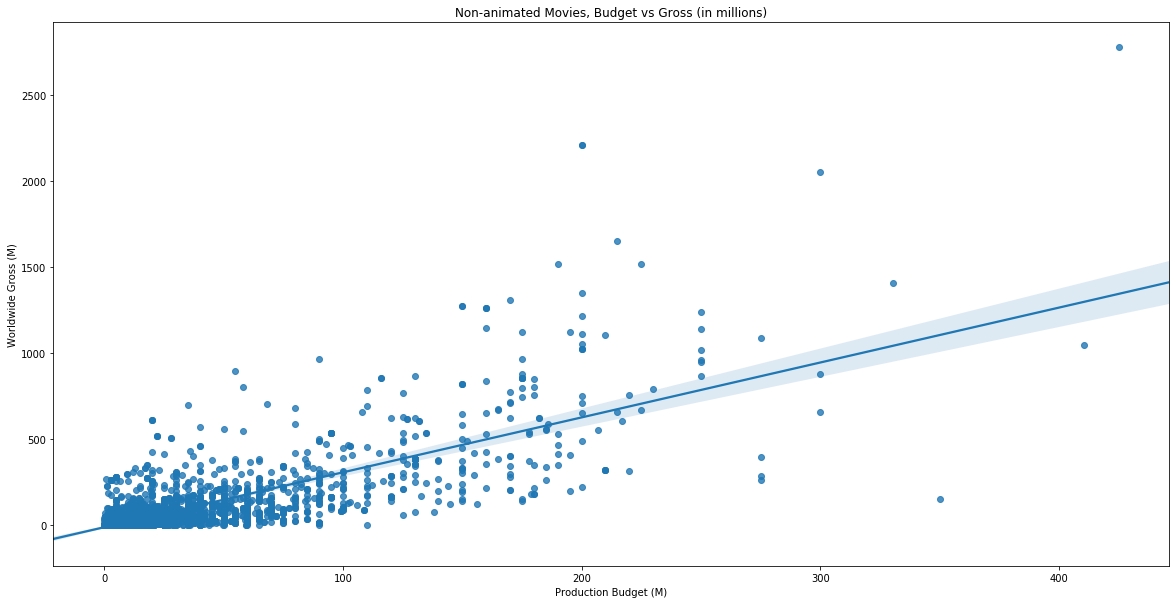

In [533]:
fig, ax = plt.subplots(figsize=(20,10))
sns.regplot(non_animated_merge_df.production_budget/1e6, non_animated_merge_df.worldwide_gross/1e6)
ax.set_xlabel("Production Budget (M)")
ax.set_ylabel("Worldwide Gross (M)")
ax.set_title("Non-animated Movies, Budget vs Gross (in millions)")
plt.savefig('Non-animated_Movies_Budget_vs_Gross.png')

In [468]:
tmdb_by_revenue_df.budget.corr(tmdb_by_revenue_df.revenue)

0.45283751226302216

In [531]:
tmdb_by_revenue_df.revenue.mean()/tmdb_by_revenue_df.budget.mean()

3.1829851409319807

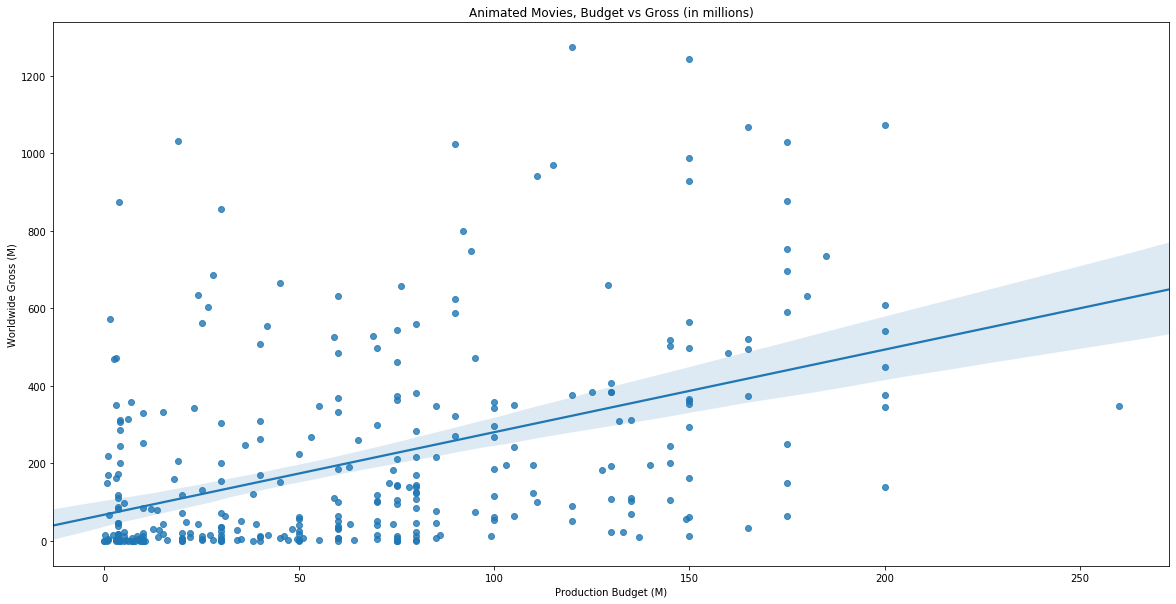

In [534]:
fig, ax = plt.subplots(figsize=(20,10))
sns.regplot(tmdb_by_revenue_df['budget']/1e6, tmdb_by_revenue_df['revenue']/1e6)
ax.set_xlabel("Production Budget (M)")
ax.set_ylabel("Worldwide Gross (M)")
ax.set_title("Animated Movies, Budget vs Gross (in millions)")
plt.savefig("graphs/Animated_Movies_Budget_vs_Gross.png")

In [449]:
original_tmdb_by_revenue_df.dropna(how='any', subset=['release_date'], inplace=True)

In [450]:
original_tmdb_by_revenue_df["release_date"].isnull().sum()

0

In [451]:
original_tmdb_by_revenue_df["release_year"] = original_tmdb_by_revenue_df["release_date"].map(lambda date : date[0:4])

In [452]:
original_tmdb_by_revenue_df["release_year"] = original_tmdb_by_revenue_df["release_year"].astype(int)

In [453]:
original_tmdb_by_revenue_df["release_year"]

0        2019
1        2013
2        2018
3        2015
4        2019
         ... 
10013    2016
10014    1973
10015    2016
10016    1963
10017    2016
Name: release_year, Length: 9350, dtype: int64

FileNotFoundError: [Errno 2] No such file or directory: 'Data/Number_animated_movies.png'

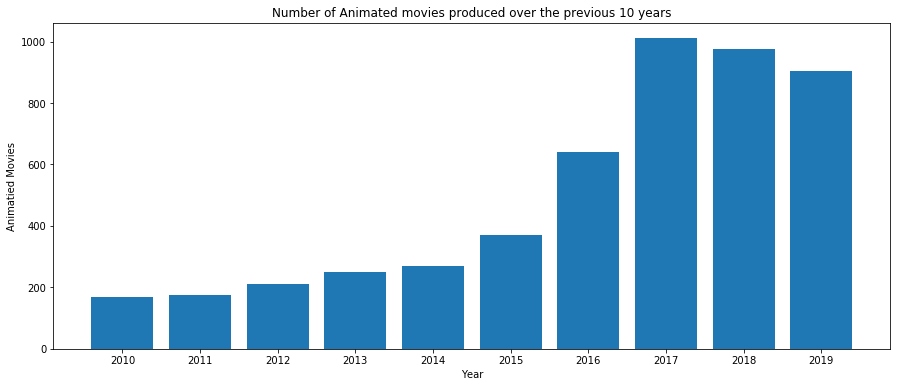

In [535]:
new_df = original_tmdb_by_revenue_df.loc[(original_tmdb_by_revenue_df['release_year'] > 2009) & (original_tmdb_by_revenue_df['release_year'] < 2020)]
y= new_df.groupby("release_year")['title'].count()
x= new_df.groupby("release_year")['title'].count().index

# Ploting The Graph

figure, ax=plt.subplots(figsize=(15,6))
ax.bar(x,y)
ax.set_title('Number of Animated movies produced over the previous 10 years')
ax.set_xlabel('Year')
ax.set_ylabel('Animatied Movies');
plt.xticks(x);
plt.savefig('Data/Number_animated_movies.png')

In [458]:
original_tmdb_by_revenue_df.columns

Index(['Unnamed: 0', 'adult', 'backdrop_path', 'belongs_to_collection',
       'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'release_year'],
      dtype='object')

In [459]:
sorted_by_revenue=original_tmdb_by_revenue_df.sort_values(by="revenue", ascending=False).head(10).reset_index(drop=True)




In [461]:
Y=sorted_by_revenue.revenue
X=sorted_by_revenue.title

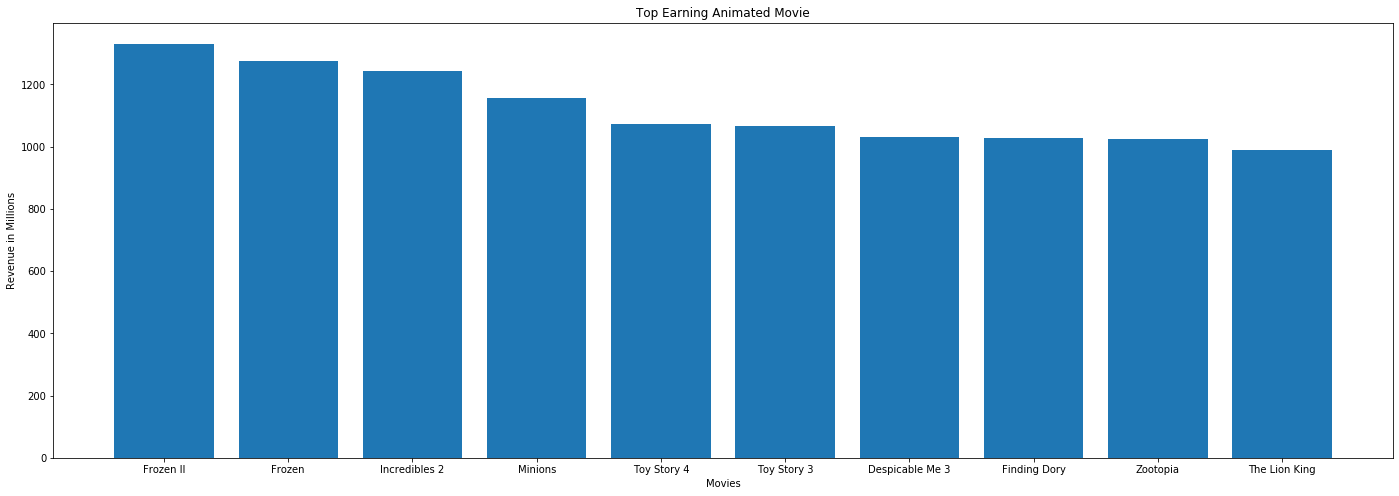

In [465]:
figure, ax=plt.subplots(figsize=(24,8))
ax.bar(X,Y/1e6)
ax.set_title('Top Earning Animated Movies')
ax.set_xlabel('Movies')
ax.set_ylabel('Revenue in Millions');

In [466]:
tmdb_by_revenue_df['budget'].describe()

count         323.00000
mean     64458986.67802
std      55238495.32522
min            30.00000
25%      15000000.00000
50%      55000000.00000
75%      97000000.00000
max     260000000.00000
Name: budget, dtype: float64

In [6]:
Studio= pd.read_csv('Data\studio_file.csv')

In [10]:
X1= Studio.groupby("studio")["title"].count().nlargest(10).index
Y1= Studio.groupby("studio")["title"].count().nlargest(10)

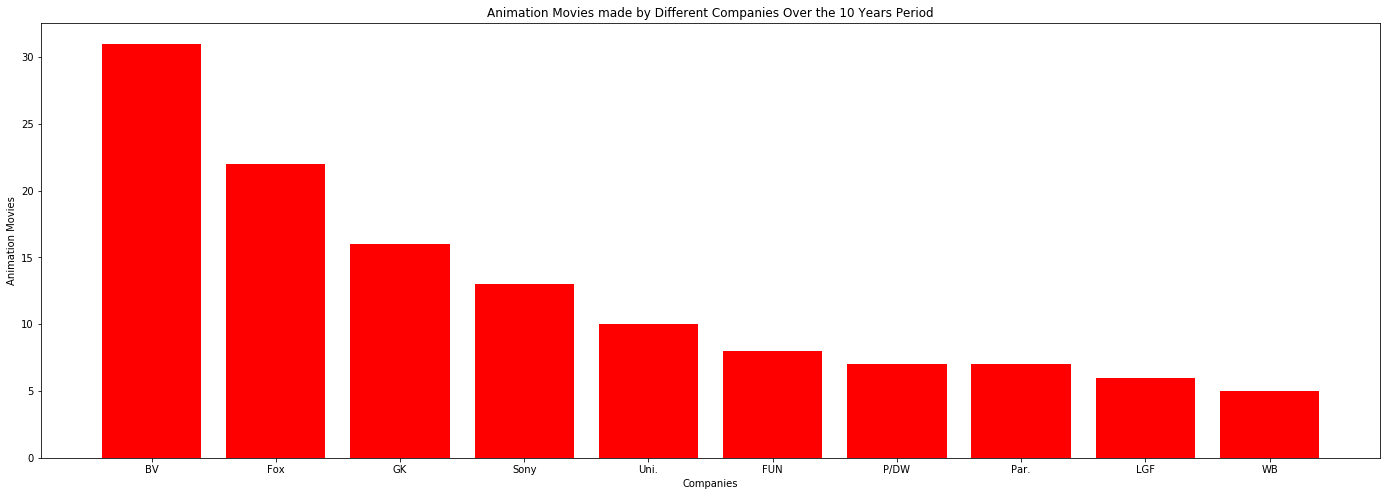

In [44]:
figure, ax=plt.subplots(figsize=(24,8))

ax.bar(X1,Y1,color= 'r')
ax.set_title('Animation Movies made by Different Companies Over the 10 Years Period')
ax.set_xlabel('Companies')
ax.set_ylabel('Animation Movies');